In [1]:
%matplotlib inline

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
combined_df = pd.read_csv("data/property_prices_combined.csv")

In [4]:
combined_df = combined_df.rename(columns={
    'Район': 'region',
    'Цена': 'price',
    'Цена / кв.м.': 'price_per_sqm',
    'Валута': 'currency',
    'Тип Апартамент': 'apartment_type',
    'Дата': 'date'
})

In [5]:
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df.sort_values(by='date', inplace=True)

combined_df.set_index('date', inplace=True)

In [6]:
combined_df

,region,price,price_per_sqm,currency,apartment_type
date,,,,,
2021-07-28,Център,564114.00,2689.00,EUR,Многостаен апартамемент
2021-07-28,Борово,180149.00,1460.31,EUR,Тристаен апартамент
2021-07-28,Бояна,184052.00,1405.14,EUR,Тристаен апартамент
2021-07-28,Бъкстон,146234.00,1357.16,EUR,Тристаен апартамент
2021-07-28,Витоша,168189.00,1338.29,EUR,Тристаен апартамент
...,...,...,...,...,...
2024-07-28,Гео Милев,55000.00,2115.39,EUR,"Гараж, паркомясто"
2024-07-28,Горна Баня,12300.00,1118.18,EUR,"Гараж, паркомясто"
2024-07-28,Дианабад,28000.00,2000.00,EUR,"Гараж, паркомясто"


#### Filter data for a specific region and property type

In [7]:
specific_data = combined_df[(combined_df['region'] == 'Банишора') & 
                            (combined_df['apartment_type'] == 'Гараж, паркомясто')]['price']

In [8]:
# Resample to monthly frequency
specific_data = specific_data.resample('m').mean()
specific_data = specific_data.interpolate() 

# specific_data = specific_data.diff().dropna()

specific_data = np.log(specific_data)
specific_data = specific_data.diff().dropna()

# Re-check stationarity
adf_result_log_diff = adfuller(specific_data)
print(f'ADF Statistic (Log-differenced): {adf_result_log_diff[0]}')
print(f'p-value (Log-differenced): {adf_result_log_diff[1]}')


ADF Statistic (Log-differenced): -2.2478729462169458
p-value (Log-differenced): 0.1893311287645837


#### Fit ARIMA model to the differenced log-transformed data

In [9]:
model = ARIMA(specific_data, order=(1, 0, 1))  # Adjust (p, d, q) as needed
model_fit = model.fit()

model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   36
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  28.414
Date:                Wed, 21 Aug 2024   AIC                            -48.827
Time:                        16:14:38   BIC                            -42.493
Sample:                    08-31-2021   HQIC                           -46.617
                         - 07-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.043      0.308      0.758      -0.070       0.097
ar.L1          0.1742      0.820      0.212      0.832      -1.434       1.782
ma.L1         -0.0109      0.840     -0.013      0.990      -1.657       1.636
sigma2         0.0121      0.002      7.232      0.000       0.009       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               458.61
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               6.27   Skew:                            -3.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   36
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  28.414
Date:                Wed, 21 Aug 2024   AIC                            -48.827
Time:                        16:14:38   BIC                            -42.493
Sample:                    08-31-2021   HQIC                           -46.617
                         - 07-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.043      0.308      0.758      -0.070       0.097
ar.L1          0.1742      0.820      0.212      0.832      -1.434       1.782
ma.L1         -0.0109      0.840     -0.013      0.9

C:\Users\galin\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


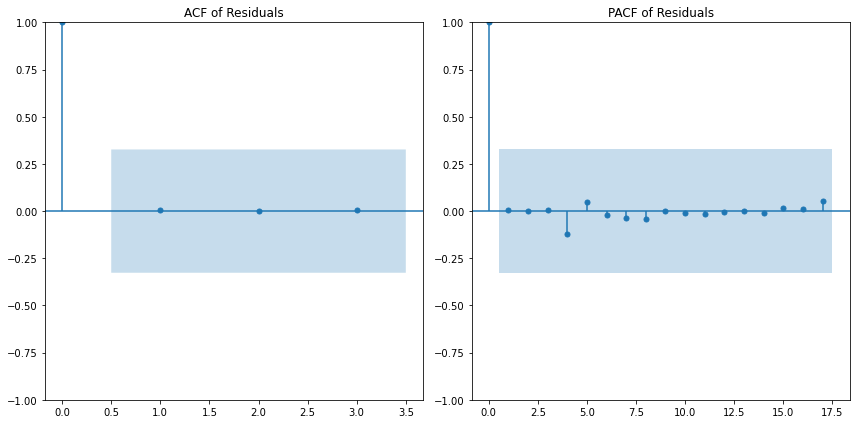

In [20]:
# # Residuals plot
# plt.figure(figsize=(10, 6))
# plt.plot(model_fit.resid)
# plt.title('Residuals')
# plt.show()

# # Q-Q plot
# sm.qqplot(model_fit.resid, line='s')
# plt.title('Q-Q Plot of Residuals')
# plt.show()

# ACF and PACF plots
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(model_fit.resid, lags=3, ax=plt.gca())
plt.title('ACF of Residuals')

plt.subplot(122)
plot_pacf(model_fit.resid, lags=17, ax=plt.gca())
plt.title('PACF of Residuals')

plt.tight_layout()
plt.show()


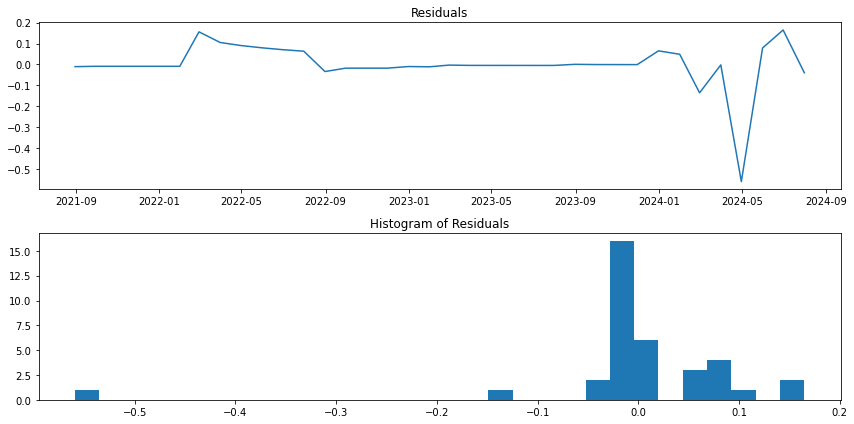

In [21]:
# Plot residuals
residuals = model_fit.resid
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(2, 1, 2)
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.show()

In [ ]:
# # Forecasting future values
# forecast_steps = 12  # Number of periods to forecast
# forecast = model_fit.get_forecast(steps=forecast_steps)
# forecast_index = pd.date_range(start=specific_data.index[-1], periods=forecast_steps+1, closed='right')
# forecast_mean = forecast.predicted_mean
# forecast_conf_int = forecast.conf_int()

# # Convert forecast back to original scale
# forecast_mean_original = np.exp(forecast_mean)
# forecast_conf_int_original = np.exp(forecast_conf_int)

# # Plot the results
# plt.figure(figsize=(12, 6))
# plt.plot(specific_data.index, specific_data, label='Observed')
# plt.plot(forecast_index, forecast_mean_original, label='Forecast', color='red')
# plt.fill_between(forecast_index, forecast_conf_int_original.iloc[:, 0], forecast_conf_int_original.iloc[:, 1], color='pink', alpha=0.3)
# plt.title('Forecast')
# plt.legend()
# plt.show()



# # Define the number of periods to forecast
# n_periods = 12  # e.g., forecasting for the next 12 months

# # Generate forecast
# forecast = model_fit.get_forecast(steps=n_periods)
# forecast_index = pd.date_range(start=specific_data.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='M')

# # Get forecasted mean and confidence intervals
# forecast_mean = forecast.predicted_mean
# forecast_conf_int = forecast.conf_int()

# # Convert forecast mean and intervals back to original scale if log-transformed
# forecast_mean_original = np.exp(forecast_mean)
# forecast_conf_int_original = np.exp(forecast_conf_int)

# # Create a DataFrame to store the forecast results
# forecast_df = pd.DataFrame({
#     'forecast': forecast_mean_original,
#     'lower_ci': forecast_conf_int_original.iloc[:, 0],
#     'upper_ci': forecast_conf_int_original.iloc[:, 1]
# }, index=forecast_index)

# # Print forecast results
# print(forecast_df)


In [22]:
# Define the number of future periods to forecast
n_periods = 12  

# Generate forecast
forecast = model_fit.get_forecast(steps=n_periods)
forecast_index = pd.date_range(start=specific_data.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='M')

# Get forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Convert forecast mean and intervals back to original scale if log-transformed
# Ensure you are converting only if you originally transformed the data
forecast_mean_original = np.exp(forecast_mean)
forecast_conf_int_original = np.exp(forecast_conf_int)

# Create a DataFrame to store the forecast results
forecast_df = pd.DataFrame({
    'forecast': forecast_mean_original,
    'lower_ci': forecast_conf_int_original.iloc[:, 0],
    'upper_ci': forecast_conf_int_original.iloc[:, 1]
}, index=forecast_index)

# Forecast results
print(forecast_df)

            forecast  lower_ci  upper_ci
2024-08-31  1.011355  0.815452  1.254322
2024-09-30  1.012912  0.814379  1.259845
2024-10-31  1.013184  0.814527  1.260291
2024-11-30  1.013231  0.814563  1.260353
2024-12-31  1.013239  0.814570  1.260363
2025-01-31  1.013241  0.814571  1.260365
2025-02-28  1.013241  0.814571  1.260365
2025-03-31  1.013241  0.814571  1.260365
2025-04-30  1.013241  0.814571  1.260365
2025-05-31  1.013241  0.814571  1.260365
2025-06-30  1.013241  0.814571  1.260365
2025-07-31  1.013241  0.814571  1.260365


#### Plot the results

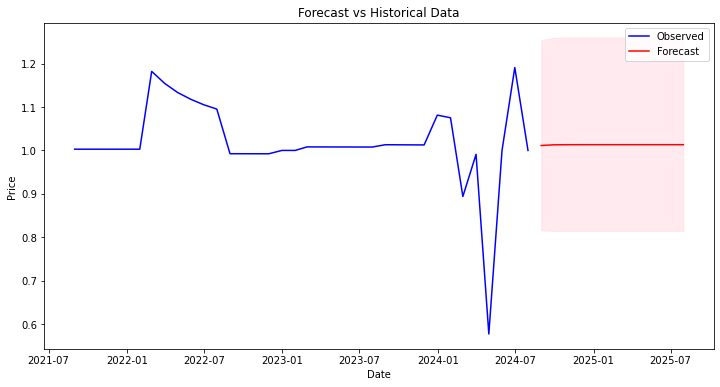

In [19]:
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(specific_data.index, np.exp(specific_data), label='Observed', color='blue')

# Plot forecast
plt.plot(forecast_index, forecast_df['forecast'], label='Forecast', color='red')

# Plot confidence intervals
plt.fill_between(forecast_index, forecast_df['lower_ci'], forecast_df['upper_ci'], color='pink', alpha=0.3)

plt.title('Forecast vs Historical Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [13]:
# # Start with ARIMA(1, 0, 1) as an example
# model = ARIMA(specific_data, order=(0, 0, 1))
# model_fit = model.fit()

# print(model_fit.summary())


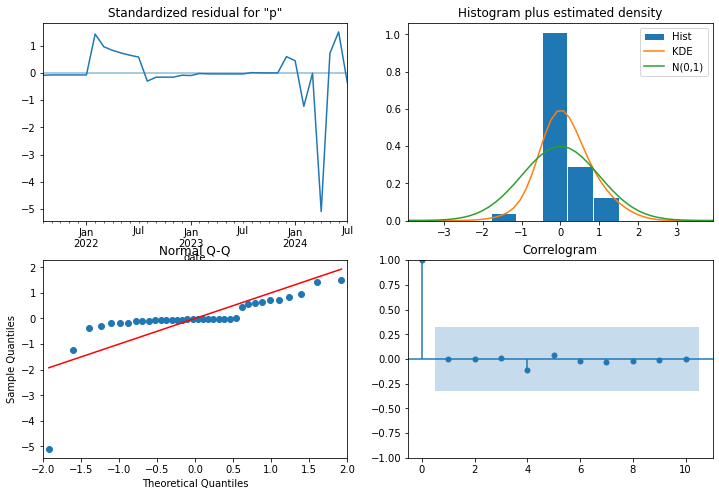

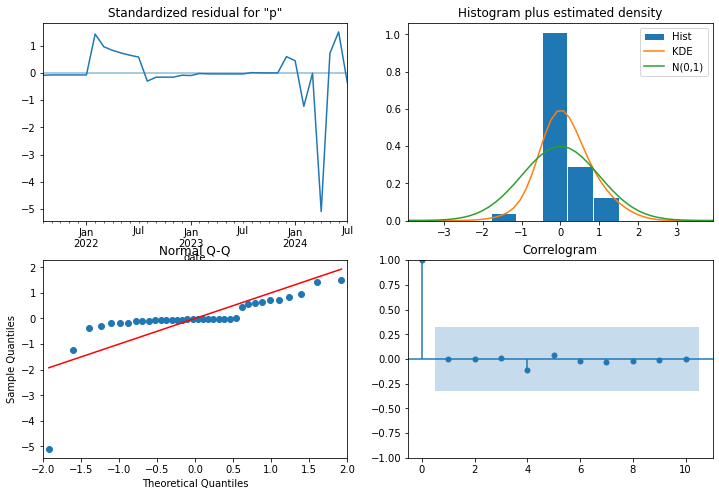

In [14]:
model_fit.plot_diagnostics(figsize=(12, 8))


In [23]:
# Forecast the next 12 time steps
forecast = model_fit.forecast(steps=12)
np.exp(forecast)

2024-08-31    1.011355
2024-09-30    1.012912
2024-10-31    1.013184
2024-11-30    1.013231
2024-12-31    1.013239
2025-01-31    1.013241
2025-02-28    1.013241
2025-03-31    1.013241
2025-04-30    1.013241
2025-05-31    1.013241
2025-06-30    1.013241
2025-07-31    1.013241
Freq: M, Name: predicted_mean, dtype: float64

In [16]:
actual_values = specific_data[-12:] 

rmse = np.sqrt(mean_squared_error(actual_values, forecast))
print(f'RMSE: {rmse}')


RMSE: 0.17502888244144002
